In [1]:
import os
import torch

# set params
ae_path = '/home/jeeves/JJ_Projects/klara_models/flux_dev/train-model/ae.safetensors'
transformer_path = '/home/jeeves/JJ_Projects/klara_models/flux_dev/train-model/flux1-dev.safetensors'
os.environ['FLUX_DEV'] = transformer_path
os.environ['AE'] = ae_path

width, height = 1024, 1024
device = torch.device('cuda')
dtype = torch.bfloat16
seed = 42
prompt = "a cute boy running on the street"

guidance = 3.5
steps = 20

In [2]:
from flux.util import load_ae, load_clip, load_flow_model, load_t5

# load models
ae = load_ae(name='flux-dev', device=device, hf_download=False)
clip = load_clip(device=device)
t5 = load_t5(device=device, max_length=512)
transformer = load_flow_model(name='flux-dev', device=device, hf_download=False)
torch.cuda.empty_cache()



Init AE


You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


Init model
Loading checkpoint


x_T shape: torch.Size([1, 16, 128, 128])
img : torch.Size([1, 4096, 64])
img_ids : torch.Size([1, 4096, 3])
txt : torch.Size([1, 512, 4096])
txt_ids : torch.Size([1, 512, 3])
vec : torch.Size([1, 768])
timesteps
[1.0, 0.983608067035675, 0.9660138487815857, 0.9470800161361694, 0.9266473650932312, 0.9045307636260986, 0.880513072013855, 0.8543381690979004, 0.8257015943527222, 0.7942392230033875, 0.7595109343528748, 0.7209802865982056, 0.677986741065979, 0.6297070980072021, 0.5751029849052429, 0.5128440856933594, 0.44119977951049805, 0.3578745722770691, 0.2597584128379822, 0.14252935349941254, 0.0]
len:  21
x_0 shape: torch.Size([1, 4096, 64])
x shape after unpacked torch.Size([1, 16, 128, 128])


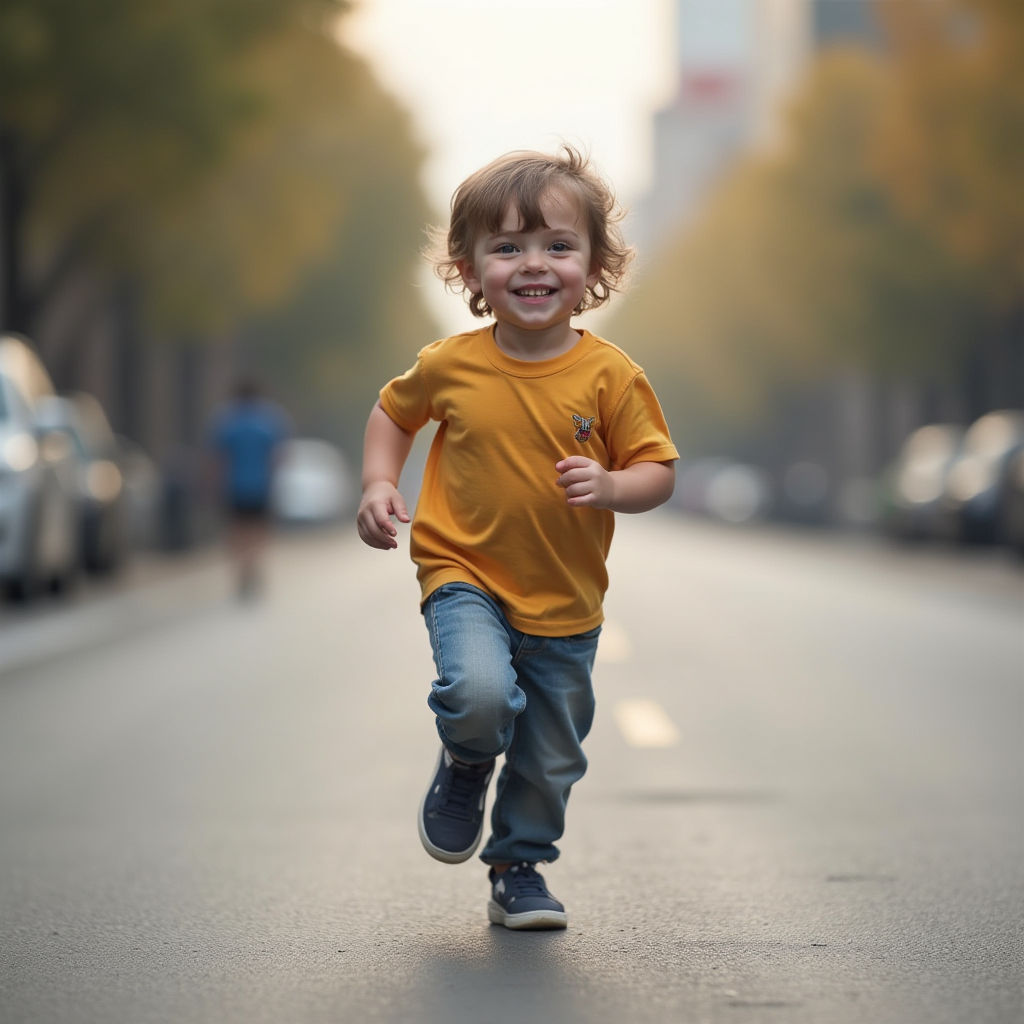

In [3]:

from PIL import Image
import einops
from flux.sampling import get_noise, prepare, denoise, get_schedule, unpack

with torch.inference_mode():
    x_T = get_noise(num_samples=1, height=height, width=width, device=device, dtype=dtype, seed=seed)
    print("x_T shape:", x_T.shape)

    inputs_dict = prepare(t5, clip, x_T, prompt)
    for k, v in inputs_dict.items():
        print(k, ':', v.shape)

    timesteps = get_schedule(steps, inputs_dict["img"].shape[1], shift=True)
    print('timesteps')
    print(timesteps)
    print("len: ", len(timesteps))

    x = denoise(transformer, **inputs_dict, guidance=guidance, timesteps=timesteps)
    print("x_0 shape:", x.shape)

    x = unpack(x.float(), height, width)
    print("x shape after unpacked", x.shape)

    with torch.autocast(device_type=device.type, dtype=torch.bfloat16):
        x = ae.decode(x)

    x = x.clamp(-1, 1)
    x = einops.rearrange(x[0], "c h w -> h w c")
    img = Image.fromarray((127.5 * (x + 1.0)).cpu().byte().numpy())

img

